# Initial Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pickle
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
# from sklearn.feature_selection import SelectFromModel
# from collections import defaultdict
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

# Preprocessing

In [2]:
# Preprocess dataset (Outputs: ids, trial_nums, predictors_df, outcomes_df, outcomes_df_shuffled)
# Import dataset
df = pd.read_csv("./../../Datasets/kieranFeatures_1-31_21-Jan-2025_avgof3_rawSA.csv").replace([np.inf, -np.inf], np.nan)

# Create Low vs High Columns
df["Lv_1_Lo"] = (df["SA1"] < 5).astype(bool)
df["Lv_2_Lo"] = (df["SA2"] < 5).astype(bool)
df["Lv_3_Lo"] = (df["SA3"] < 5).astype(bool)
df["Tot_Lo"] = (df["SAtotal"] < 15).astype(bool)

# Impute missing values with mean of column
for col in df.columns:
    df[col] = df[col].fillna(value = df[col].mean())

# Split up dataset
ids = df["ID"].astype(np.uint8)
predictors_df = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]).astype(np.float64)
outcomes_df = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]

# Divide up dataframe
ids = df["ID"]
ECG_df = df.loc[:, [col for col in df if col.startswith("ECG")]]
EDA_df = df.loc[:, [col for col in df if col.startswith("EDA")]]
EEG_df = df.loc[:, [col for col in df if col.startswith("EEG")]]
EYE_df = df.loc[:, [col for col in df if col.startswith("EYE")]]
fNIRS_df = df.loc[:, [col for col in df if col.startswith("fNIRS")]]
RSP_df = df.loc[:, [col for col in df if col.startswith("RSP")]]
sensor_dfs = [(ECG_df, "ECG"), (EDA_df, "EDA"), (EEG_df, "EEG"), (EYE_df, "EYE"), (fNIRS_df, "fNIRS"), (RSP_df, "RSP")]

# Train-Validation-Test Splits
ids_cv, ids_test = train_test_split(ids, test_size = 0.15, random_state = 42, stratify = ids)
ids_train, ids_val = train_test_split(ids_cv, test_size = 0.17647, random_state = 42, stratify = ids_cv) # 15% of original dataframe for validation set

outcomes_train = outcomes_df.loc[ids_train.index]
outcomes_val = outcomes_df.loc[ids_val.index]
outcomes_test = outcomes_df.loc[ids_test.index]

# Free up memory
del col, df, predictors_df, ids_cv

# SA Level 1

## Hyperparameter Tuning

In [3]:
def hyperparameter_tune_sensor_model(df, level):
    """
    Performs custom Cross Validation to find the best hyperparameters for the sensor model.
    Train-Validate-Test Split: 70-15-15 done.
    5-Fold Stratifies Cross Validation is done on the training set with respect to the ids.
    The best model is selected based on the F1 score.
    """

    # Train-Validate-Test Split
    X_train, y_train = df.iloc[ids_train.index], outcomes_train[level]

    Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    best_model_C = 1.0
    best_model_score = 0.0

    # Get Best C Hyperparameter
    for c_param in Cs:
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
        model_scores = []

        # Iterate Through All Possible Folds
        for _, (train_index, test_index) in enumerate(skf.split(X_train, ids_train)):
            # Train-Test Split for Cross Validation of Base Models
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            # Scale the Training Data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_test_scaled = scaler.transform(X_test_fold)

            # Fit Model
            model = LogisticRegression(
                C = c_param,
                solver = "saga",
                max_iter = 20000,
                class_weight = "balanced",
                n_jobs = -1,
                random_state = 42
            )

            model.fit(X_train_scaled, y_train_fold)
            model_scores.append(f1_score(y_test_fold, model.predict(X_test_scaled)))

        # Update Best Model if CV Score is Better
        if np.mean(model_scores) > best_model_score:
            best_model_C = c_param
            best_model_score = np.mean(model_scores)

    return best_model_C

In [4]:
for sensor_df, sensor_name in sensor_dfs:
    print(sensor_name + ": ", end = "")
    print(hyperparameter_tune_sensor_model(sensor_df, "Lv_1_Lo"))

ECG: 1
EDA: 100
EEG: 1
EYE: 0.01
fNIRS: 1
RSP: 100


## Training Base Models

In [5]:
# Setup Models
ECG_model = LogisticRegression(
    C = 1.0,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

EDA_model = LogisticRegression(
    C = 100.0,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

EEG_model = LogisticRegression(
    C = 1.0,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

EYE_model = LogisticRegression(
    C = 0.01,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

fNIRS_model = LogisticRegression(
    C = 1,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

RSP_model = LogisticRegression(
    C = 100,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

In [6]:
def get_base_model_validation_predictions(sensor_name, model, df, level):
    # Train-Validation-Test Split
    X_train, X_val = df.iloc[ids_train.index], df.iloc[ids_val.index]
    y_train = outcomes_train[level]

    # Scale the Training Data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train Model
    model.fit(X_train_scaled, y_train)

    # Get Validation Predictions and Probabilities
    validation_predictions = np.array(model.predict(X_val_scaled))
    validation_prediction_probabilities = np.array(model.predict_proba(X_val_scaled)[:, 1])

    # Naming Stuff
    prediction_column_name = sensor_name + "_Prediction"
    prediction_probability_column_name = sensor_name + "_Prediction_Probability"

    predictions_df = pd.DataFrame({prediction_column_name: validation_predictions, prediction_probability_column_name: validation_prediction_probabilities})

    return predictions_df, model, scaler

In [7]:
base_model_predictions = pd.DataFrame()
trained_base_models = {}
trained_scalers = {}
sensor_details = [(ECG_df, "ECG", ECG_model), (EDA_df, "EDA", EDA_model), (EEG_df, "EEG", EEG_model), (EYE_df, "EYE", EYE_model), (fNIRS_df, "fNIRS", fNIRS_model), (RSP_df, "RSP", RSP_model)]

for sensor_df, sensor_name, sensor_model in sensor_details:
    predictions, trained_model, trained_scaler = get_base_model_validation_predictions(sensor_name, sensor_model, sensor_df, "Lv_1_Lo")
    base_model_predictions = pd.concat([base_model_predictions, predictions], axis = 1)
    trained_base_models[sensor_name] = trained_model
    trained_scalers[sensor_name] = trained_scaler

## Hyperparameter Tuning for Meta-Model

In [9]:
def hyperparameter_tune_meta_model(df, level):
    # df should be the dataframe with the base model predictions
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    model = LogisticRegressionCV(
        Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        cv = skf,
        scoring = "f1",
        solver = "saga",
        max_iter = 20000,
        class_weight = "balanced",
        n_jobs = -1,
        random_state = 42
    )

    pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipeline.fit(df, outcomes_val[level])

    return pipeline[1].C_

In [10]:
print(hyperparameter_tune_meta_model(base_model_predictions, "Lv_1_Lo"))

[0.01]


## Train Meta-Model

In [11]:
# Setup Meta Model
meta_model = LogisticRegression(
    C = 0.01,
    solver = "saga",
    max_iter = 20000,
    class_weight = "balanced",
    n_jobs = -1,
    random_state = 42
)

In [12]:
def fit_meta_model(df, model, level):
    # df should be the dataframe with the base model predictions
    # Scale the Data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # Fit Model
    model.fit(X_scaled, outcomes_val[level])

    return model, scaler

In [13]:
meta_model, meta_model_scaler = fit_meta_model(base_model_predictions, meta_model, "Lv_1_Lo")

In [14]:
def get_base_model_test_predictions(sensor_df, sensor_name, scaler, model):
    X_test = sensor_df.iloc[ids_test.index]

    # Scale the Data
    X_test_scaled = scaler.transform(X_test)

    # Get Test Predictions and Probabilities
    test_predictions = np.array(model.predict(X_test_scaled))
    test_prediction_probabilities = np.array(model.predict_proba(X_test_scaled)[:, 1])

    # Naming Stuff
    prediction_column_name = sensor_name + "_Prediction"
    prediction_probability_column_name = sensor_name + "_Prediction_Probability"

    predictions_df = pd.DataFrame({prediction_column_name: test_predictions, prediction_probability_column_name: test_prediction_probabilities})

    return predictions_df

In [15]:
# Get Base Model Predictions on Test Set
base_model_test_predictions = pd.DataFrame()

for sensor_df, sensor_name in sensor_dfs:
    predictions = get_base_model_test_predictions(sensor_df, sensor_name, trained_scalers[sensor_name], trained_base_models[sensor_name])
    base_model_test_predictions = pd.concat([base_model_test_predictions, predictions], axis = 1)

In [16]:
scaled_test_predictions = meta_model_scaler.transform(base_model_test_predictions)
f1_performance = f1_score(outcomes_test["Lv_1_Lo"], meta_model.predict(scaled_test_predictions))
accuracy_performance = accuracy_score(outcomes_test["Lv_1_Lo"], meta_model.predict(scaled_test_predictions))
print("F1: " + str(f1_performance))
print("Accuracy: " + str(accuracy_performance))

F1: 0.5555555555555556
Accuracy: 0.6444444444444445


In [17]:
f1_always_true = f1_score(outcomes_test["Lv_1_Lo"], np.ones(outcomes_test["Lv_1_Lo"].shape))
f1_baseline = (2 * np.mean(outcomes_test["Lv_1_Lo"] * 0.5) / (np.mean(outcomes_test["Lv_1_Lo"]) + 0.5))
accuracy_always_false = accuracy_score(outcomes_test["Lv_1_Lo"], np.zeros(outcomes_test["Lv_1_Lo"].shape))
accuracy_baseline = 0.5

print(stats.ttest_1samp(a = f1_performance, popmean = f1_always_true))
print(stats.ttest_1samp(a = f1_performance, popmean = f1_baseline))
print(stats.ttest_1samp(a = accuracy_performance, popmean = accuracy_always_false))
print(stats.ttest_1samp(a = accuracy_performance, popmean = accuracy_baseline))

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.int64(0))
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.int64(0))
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.int64(0))
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.int64(0))


/home/jshen/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/jshen/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


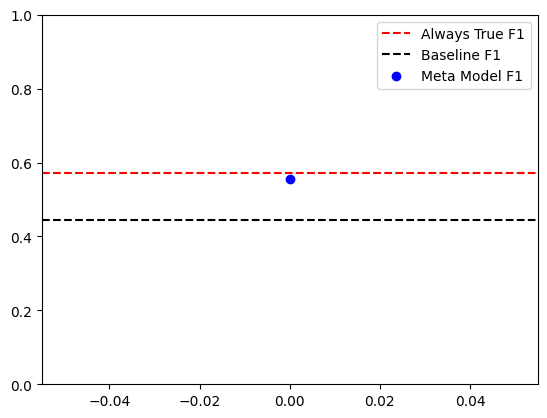

In [18]:
plt.axhline(y = f1_always_true, color = "r", linestyle = "--", label = "Always True F1")
plt.axhline(y = f1_baseline, color = "black", linestyle = "--", label = "Baseline F1")
plt.scatter(x = 0, y = f1_performance, color = "blue", label = "Meta Model F1")

plt.ylim(0, 1)
plt.legend()

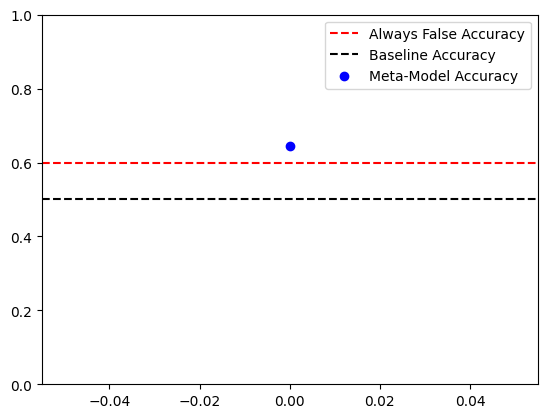

In [ ]:
plt.axhline(y = accuracy_always_false, color = "r", linestyle = "--", label = "Always False Accuracy")
plt.axhline(y = accuracy_baseline, color = "black", linestyle = "--", label = "Baseline Accuracy")
plt.scatter(x = 0, y = accuracy_performance, color = "blue", label = "Meta-Model Accuracy")

plt.ylim(0, 1)
plt.legend()